In [1]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs_copy
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
import math
from astropy.table import Table

In [21]:
# read in GBM GRB catalog (first 9 years)
#gbmfit=fits.open('gbmgrbcat_copy.fits')
#gbm=gbmfit[1].data

#read in GBM Trigger Catalog
#trigfit=fits.open('gbmtrigcat.fits')
#trig=trigfit[1].data
#(np.shape(gbm))
#print(Table.read('gbmtrigcat.fits'))
#print(Table.read('gbmgrbcat_copy.fits'))





gbmfit=fits.open('GBMsamplecat.fits')
gbm=gbmfit[1].data

trigfit=fits.open('gbmtrigcat.fits')
trig=trigfit[1].data

TRIGGER_NAME      NAME         RA    ...   TRIGGER_TIME  TRIGGER_TIMESCALE
                             DEGREE  ...       MJD               MS       
------------ -------------- -------- ... --------------- -----------------
BN120403857  GRB120403857    55.3384 ... 56020.856927003              1024
BN140912846  TGF140912846      44.05 ... 56912.845875803                16
BN120227725  GRB120227725     256.73 ... 55984.725475166              1024
BN140630748  TGF140630748   128.7667 ... 56838.747788306                16
BN141205018  GRB141205018     294.61 ... 56996.017706164              2048
BN180630467  GRB180630467    48.9589 ... 58299.466601915              1024
BN170116238  GRB170116238      72.94 ... 57769.238371056              1024
BN170909434  TGF170909434      43.85 ... 58005.433674278                16
BN100911473  TGF100911473      176.0 ... 55450.472675715                16
BN091026550  GRB091026550    276.573 ... 55130.549687727              4096
         ...            .

In [3]:
## code to use when reading in GBM effective area in order to get data into the desired format
def getGBMdata(gbmfile=None):
    """Reads the GBM NaI effective area file and returns a numpy array
    with two columns ``energy`` and ``aeff``.
    Parameters
    ----------
    gbmfile : string
       Name of file that contains the GBM data.
    Returns
    ----------
    gbmdata : array 
    numpy array with two columns ``energy`` and ``aeff``
    """
    
    return np.genfromtxt(gbmfile,skip_header=2,names=('energy', 'aeff'))


In [4]:
## bit of useful code for interpolating in log space
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

def loginterpol2d(x,y,z,x1,y1):

    wz=np.where(z==0)[0]
    zz=z
    zz[wz]=1.
    f=interpolate.interp2d(x,y,np.log10(zz),bounds_error=False,fill_value="extrapolate",kind='linear')
    z1=10**f(x1,y1)

In [5]:
## generate random positions on the sky with equal area probability
def random_sky(n=1):

    u=np.random.rand(n)
    v=np.random.rand(n)

    phi=2*np.pi*u
    theta=np.arccos(2*v-1.)

    dec=-np.degrees(theta-np.pi/2.)
    ra=np.degrees(np.pi*2-phi)

    return ra,dec

In [27]:
#function to match GRBs in the Trigger catalog to those in the grb catalog so that we can create an array of the arrays in both
#we will ultimately use this to compare the timescales of the trigger timescale and the peak flux interval

def match_catalogs_name(name1,name2):

    ind_dict = dict((q,e) for e,q in enumerate(name1))
    inter = set(ind_dict).intersection(name2)
    m1 = [ind_dict[element] for element in inter]
    print(np.shape(m1))
    
    ind_dict = dict((q,e) for q,e in enumerate(name2))
    inter = set(ind_dict).intersection(name1)
    m2 = [ind_dict[element] for element in inter]
    print(np.shape(m2))
    
    return m1,m2

In [34]:
#creating array of grbs
m1, m2 = match_catalogs_name(trig['NAME'],gbm['NAME'])
#np.shape(matched)
type(m1)


triggergrbs = trig[m1]
print(triggergrbs)

np.shape(triggergrbs)

(2352,)
(0,)
[('BN090809978', 'GRB090809978', 95.25, 0.16, 55052.976346868, 55052.98345808, 55052.977946889, 2048)
 ('BN110509142', 'GRB110509142', 180.81, -34.0, 55690.140527488, 55690.147638724, 55690.142115662, 4096)
 ('BN100522157', 'GRB100522157', 6.9867, 9.4023, 55338.155260414, 55338.162371626, 55338.156855251, 128)
 ...
 ('BN160924253', 'GRB160924253', 97.12, 71.32, 57655.251294227, 57655.258405451, 57655.252882399, 4096)
 ('BN090726218', 'GRB090726218', 240.45, 36.75, 55038.216531423, 55038.218285526, 55038.218137375, 1024)
 ('BN151211672', 'GRB151211672', 262.49, 39.26, 57367.670402847, 57367.677419258, 57367.671927315, 256)]


(2352,)

In [35]:
## read in the GBM Aeff
aeff_gbm = getGBMdata('/home/alyson/NASA/Simulation/BurstCube/Users/ajoens/gbm_effective_area.dat')

In [36]:
## separate GBM short & long GRBs
w=np.where(gbm['FLUX_1024']>0)
gbm=gbm[w]
s=np.where((gbm['T90'] <= 2.)&((gbm['PFLX_SPECTRUM_STOP']-gbm['PFLX_SPECTRUM_START'])>0))[0]
l=np.where(gbm['T90'] > 2.)[0]
m=np.where(gbm['PFLX_BEST_FITTING_MODEL'][s] == ' ')


In [37]:
#Integrating the best fit spectrum for each GRB in the energy range of 50-300 KeV to get max. observed photon flux. 
#This will give us the photon flux in units of ph/cm^2/s. Currently only doing this for GBM and will then add in BurstCube
mo=gbm['PFLX_BEST_FITTING_MODEL'][s]
#f=np.zeros([len(s),nsims]) # produces an array of zeros with the given shape and type
pf=np.zeros(len(s))
gbmcr=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
for i in range(len(s)):
    #for j in range(nsims):
        #E=np.array(eng[w[j]+1:w[j+1]+1])
        #AeffBC=loginterpol(E,aeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE) #eng[w[j]+1:w[j+1]+1])
        
        #Aratio=(AeffBC/AeffGBM)
        # not sure what *grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]] is and why we need it. I think we only need the model photon flux times the aeffGBM and we want it integrated over the energy range provided in outE
        # this should give us an array of the maximum observed photon flux for GBM
        if mo[i]=='PFLX_PLAW':
            gbmcr[i]=np.trapz(gbm['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]]),outE)
            #pf[i]=gbm['PFLX_PLAW_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_COMP':
            gbmcr[i]=np.trapz(gbm['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbm['PFLX_COMP_INDEX'][s[i]],gbm['PFLX_COMP_EPEAK'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbm['PFLX_COMP_INDEX'][s[i]],gbm['PFLX_COMP_EPEAK'][s[i]]),outE)
            #pf[i]=gbm['PFLX_COMP_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_BAND':
            gbmcr[i]=np.trapz(gbm['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbm['PFLX_BAND_ALPHA'][s[i]],gbm['PFLX_BAND_EPEAK'][s[i]],gbm['PFLX_BAND_BETA'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbm['PFLX_BAND_ALPHA'][s[i]],gbm['PFLX_BAND_EPEAK'][s[i]],gbm['PFLX_BAND_BETA'][s[i]]),outE)
            #pf[i]=gbm['PFLX_BAND_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_SBPL':
            gbmcr[i]=np.trapz(gbm['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbm['PFLX_SBPL_INDX1'][s[i]],gbm['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbm['PFLX_SBPL_INDX1'][s[i]],gbm['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
            #pf[i]=gbm['PFLX_SBPL_PHTFLUX'][s[i]]

pf = np.array(pf)
gbmcr = np.array(gbmcr)


(339,)


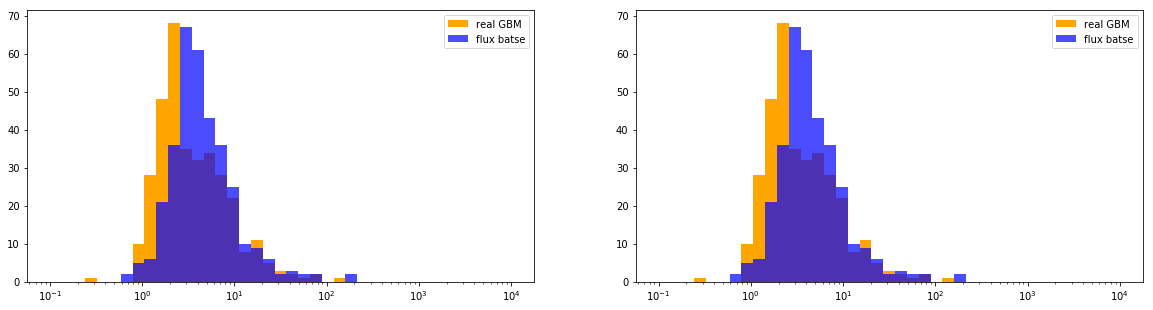

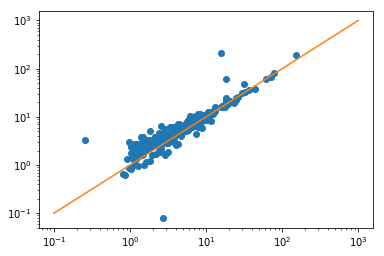

In [38]:
#plot Batse[64] against pf to see if they are the same
flux=gbm['FLUX_BATSE_64'][s]
fluxshape=np.shape(flux)
print(fluxshape)

#Creating plot of peak flux versus counts for real and simulated GBM
#print(np.log10(pf[w]))
fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# this is the simulated GBM
plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()

plot.plot(pf,flux, linestyle='None', marker='o')
plot.xscale('log')
plot.yscale('log')
plot.plot([1e-1,1e3],[1e-1,1e3])
plot.show()

In [39]:
#define probability
p = np.array((np.arange(pf.shape[0])+1)**(-1.0))
p=p/sum(p)
#randomly sample from the array of peak fluxes found above using our probability function found above so we draw more low peak fluxes
# This is creating our "intrinsic" sample
r=np.random.choice(pf.shape[0], 3000, replace=True, p=p)
print(min(r),max(r))
simpfsample = np.array(pf[r])
simgbmcr = np.array(gbmcr[r])
#print(np.shape(simpfsample))
#print(simpfsample)
#print(r)

0 338
(3000,)
[7.98899872 7.59656757 2.29712374 ... 8.35482784 2.52680473 2.23203975]
[196 171   0 ...  35  23 329]


In [40]:
#Doing the same as above but for our simulated sample in order to get the max observed photon flux of the sim. sample.
#outE=np.logspace(np.log10(50),np.log10(300),3940) 
#simgbmcr=np.zeros(len(simpfsample))
#for i in range(len(simpfsample)):
#    AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE)#eng[w[j]+1:w[j+1]+1])
#    simgbmcr[i] = simpfsample[i]*AeffGBM
#print(simgbmcr)

In [41]:
# we want to solve for the number of detected counts. We need to create two more arrays- 1 for exposure and the other for interval.
#Interval is given in the GBM catalog however we need to know exposure. This should be found from the exposure map for each burst.
#this all together will give us the number of source photons

## setup GBM
gbm_pointings = {'01': ('45:54:0','20:36:0'),
            '02': ('45:6:0','45:18:0'),
            '03': ('58:24:0','90:12:0'),
            '04': ('314:54:0','45:12:0'),
            '05': ('303:12:0','90:18:0'),
            '06': ('3:24:0','89:48:0'),
            '07': ('224:54:0','20:24:0'),
            '08': ('224:36:0','46:12:0'),
            '09': ('236:36:0','90:0:0'),
            '10': ('135:12:0','45:36:0'),
            '11': ('123:42:0','90:24:0'),
            '12': ('183:42:0','90:18:0')}

fermi = Spacecraft(gbm_pointings,window=0.1)

res = 250
rr,dd = np.meshgrid(np.linspace(0,360,res,endpoint=False),np.linspace(-90,90,res))
exposure_positions = np.vstack([rr.ravel(),dd.ravel()])
gbm_exposures = np.array([[ detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in fermi.detectors])

In [42]:
#using SkyCoord to convert coordinates to degrees and solve for distances.
def separation(ra1,dec1,ra2,dec2):

    c=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
    d=SkyCoord(ra=ra2*u.deg,dec=dec2*u.deg)
    dist=c.separation(d)
    dist=dist.value

    return dist

In [43]:
# now that GBM's pointings are set up we will throw GRBs at it and determine it's exposure for each GRB. 
#generate GRBs and throw them at GBM

def throw_grbs(fermi,minflux,maxflux):
    
    nsims=int(np.round(len(simpfsample))) 
    ra,dec=random_sky(nsims)
    ra=np.array(ra)-180
    dec=np.array(dec)
    #sigma=0.65,mean=1.5
 
    #change the sigma and mean in order to create a log fit for simulated GBM. Automate this fit.
    #flux=np.random.lognormal(size=nsims,sigma=0.55,mean=0.6)*(np.log10(maxflux)-np.log10(minflux))+np.log10(minflux)

    #GBM exposures for each random GRB. Believe this is an array with the different exposures for each detector
    randgbmexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in fermi.detectors])
    print("randgbmexposures=", randgbmexposures)

    #Order randgbmexposures into descending order
    for column in randgbmexposures.T:
        newrandgbm = -np.sort(-randgbmexposures.T) 
    gbmexposures = np.transpose(newrandgbm)
    print("gbmexposures=",gbmexposures)
    
    #Select the second highest value. 
    #We will use this to ensure the second highest exposure detector has a sig >4.5
    secondhighest = gbmexposures[1,:]
    print("Second highest =", secondhighest)

        
    return gbmexposures, secondhighest, randgbmexposures

In [64]:
#define the peak flux interval
interval = gbm['PFLX_SPECTRUM_STOP'][s]-gbm['PFLX_SPECTRUM_START'][s]

print(interval)

w=np.shape(interval)
print(w)

triginterval = trig['End_Time'][s]-trig['Time'][s]


print(triginterval)
wt=np.shape(triginterval)
print(wt)
print(gbm['Actual_64ms_Interval'][s])

[0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.

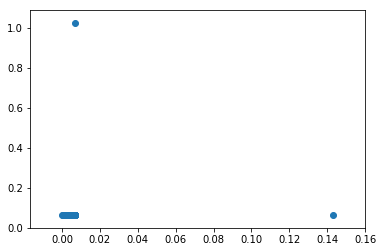

In [61]:
trigvsgbm = plot.scatter(triginterval, interval)

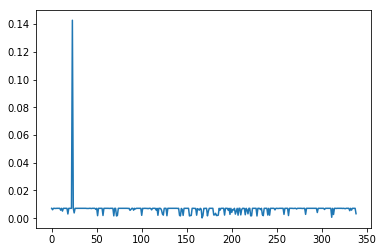

In [56]:
triggertimescale = plot.plot(triginterval)

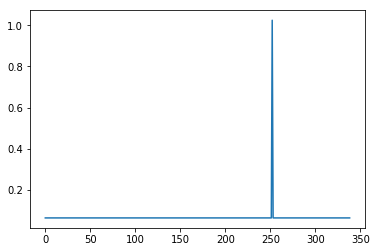

In [62]:
gbmtrigger = plot.plot(interval)

In [65]:
#flux=simpf this is in ph/sec
flux=simpfsample
minflux=min(flux)
maxflux=max(flux)
gbmexposures, secondhighest, randgbmexposures = throw_grbs(fermi,minflux,maxflux)

#sechighestsize=np.shape(secondhighest)
#print(sechighestsize)
#execute function defined above
#throw_grbs(fermi,minflux,maxflux,pf)

randgbmexposures= [[0.         0.         0.         ... 0.         0.7978219  0.64081017]
 [0.         0.         0.         ... 0.         0.91892607 0.59138951]
 [0.         0.         0.         ... 0.         0.75742454 0.74585136]
 ...
 [0.         0.         0.         ... 0.         0.         0.7996183 ]
 [0.         0.         0.         ... 0.         0.         0.91591352]
 [0.         0.         0.         ... 0.         0.         0.11181563]]
gbmexposures= [[0.         0.         0.         ... 0.         0.91892607 0.91591352]
 [0.         0.         0.         ... 0.         0.80003399 0.7996183 ]
 [0.         0.         0.         ... 0.         0.7978219  0.74585136]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Second highest = [0.         0.         0.         ... 0.         0.80003399 0.7

In [66]:
#Solve for the number of detected counts which will equal our source photons
#Should this really be multiplied by pf or should it be multiplied by flux? pf is calculated from GBM catalog#
#secondhighest=1
source = simgbmcr*secondhighest*interval[r]
#q=np.shape(simpfsample)
#print(q)
#y=np.shape(secondhighesit)
#print(y)
x=np.shape(interval)
#print(x)
print(source)
print(type(interval[r]))
print(type(secondhighest))
print(type(simgbmcr))
#print(simpfsample)

[ 0.          0.          0.         ...  0.         15.69675788
 13.99560223]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [67]:
#Assuming a background count rate. units: cts/s
bckgrd=1000
#scale the background count rate 
scaledbckgrd = bckgrd*secondhighest*interval[r]
print(scaledbckgrd)

[ 0.          0.          0.         ...  0.         51.20217551
 51.17557095]


In [68]:
#calculate the significance of the second highest exposure detector. If the significance is greater than 4.5 sigma than the burst is detectable.
#creating an array of zeros that I can 
detect = np.zeros(len(simpfsample))
for u in range(len(simpfsample)):
    sig = source[u] / (math.sqrt(source[u] + scaledbckgrd[u]))
    if sig > 4.5:
        detect[u] = 1.0
    else:
        detect[u] = 0.0

print(detect)


[0. 0. 0. ... 0. 0. 0.]


/home/alyson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


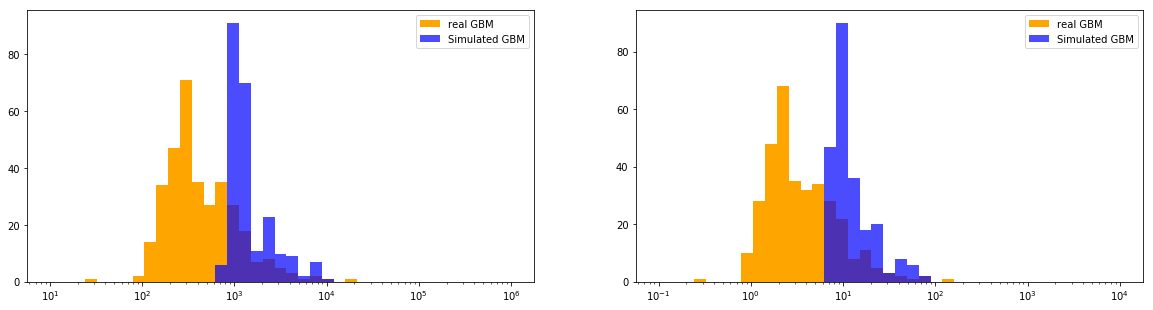

In [69]:
#Creating plot of peak flux versus counts for real and simulated GBM
w=np.where(pf>0)[0]
wg = np.where(simgbmcr*detect>0)[0]
#print(np.log10(pf[w]))
fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,6,40),color='orange')
plot.hist(simgbmcr[wg],label='Simulated GBM',bins=np.logspace(1,6,40),alpha=0.7,color='blue')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(pf[w],label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# this is the simulated GBM
plot.hist(simpfsample[wg],label='Simulated GBM',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()
        